In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [3]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
# from imblearn.over_sampling import RandomOverSampler

In [3]:
from sklearn.ensemble import AdaBoostClassifier
import time

In [95]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

### 데이터 가져오기 - Ordinal Brands

In [23]:
df = pd.read_csv('../Outputs/brand_df2.csv', encoding='cp949', index_col = 0)
df.head()

,사업장명,시설총규모,neighbors,횡단보도,distance,1층 여부,층수 2개 이상,지하 only,길,대로,...,남성 실업률,여성 실업률,15-29세 실업률,30-59세 실업률,60세이상 실업률,수출물가지수,수입물가지수,음식점포함_소매판매액지수(경상지수),음식점포함_소매판매액지수(불변지수),폐업여부
0,바론,19.0,0,1,194,1,0,0,1,0,...,5.300000,5.366667,9.7,3.7,7.3,99.573333,107.296667,98.066667,99.133333,0
1,바론,19.0,0,1,194,1,0,0,1,0,...,5.233333,4.300000,10.4,3.3,4.7,101.456667,111.380000,102.633333,102.933333,0
2,바론,19.0,0,1,194,1,0,0,1,0,...,4.166667,3.700000,8.2,3.1,2.8,101.070000,110.656667,101.733333,102.166667,0
3,바론,19.0,0,1,194,1,0,0,1,0,...,3.633333,3.233333,6.6,2.8,2.8,97.673333,108.026667,109.950000,110.300000,0
4,바론,19.0,0,1,194,1,0,0,1,0,...,4.166667,4.866667,8.9,3.2,5.0,96.820000,105.010000,94.933333,94.966667,0


In [24]:
X = df.drop(columns=['사업장명', '폐업여부'])
y = df['폐업여부']

### Stratified sampling

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)
print(y_train.value_counts(), y_train.value_counts()[1]/sum(y_train.value_counts()))
print(y_test.value_counts(), y_test.value_counts()[1]/sum(y_test.value_counts()))

폐업여부
0    199834
1      3070
Name: count, dtype: int64 0.015130307928872768
폐업여부
0    66612
1     1023
Name: count, dtype: int64 0.015125304945664227


In [12]:
smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_smt, y_smt = smoteto.fit_resample(X_train, y_train)

In [ ]:
res = pd.read_csv('../Outputs/resampled.csv', encoding='cp949', index_col = 0)
test = pd.read_csv('../Outputs/test_set.csv', encoding='cp949', index_col = 0)
res = res.sample(frac=1).reset_index(drop=True)
test - test.sample(frac=1).reset_index(drop=True)

In [87]:
X_res, y_res = res.iloc[:, :-1], res.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

In [89]:
ada_model = AdaBoostClassifier(random_state = 42)
ada_model.fit(X_res, y_res)

c:\Users\HOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(random_state=42)

In [22]:
# skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
# gs = GridSearchCV(estimator = ada_model, param_grid = param_grid,
#                   cv=skf, n_jobs = -1, verbose=2, random_state = 42)

In [ ]:
# estimator = gs.best_estimator_
# print(gs.best_params_)
# print(gs.best_score_)

In [90]:
y_pred_prob = pd.Series(ada_model.predict_proba(X_test)[:, 1])
y_pred = ada_model.predict(X_test)

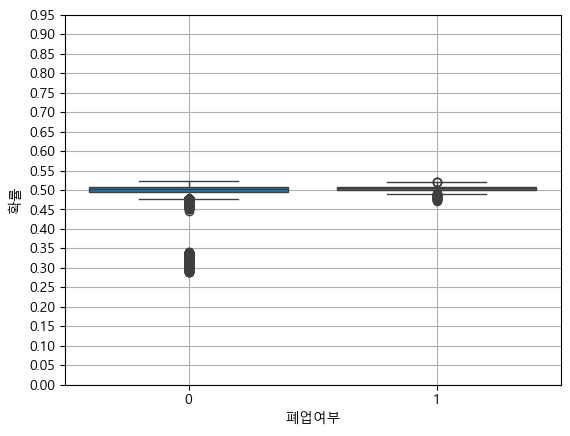

In [103]:
temp = pd.concat([y_test, y_pred_prob.rename('확률')], axis=1)
sns.boxplot(x='폐업여부', y='확률', data=temp)
plt.grid(True)
plt.yticks(np.arange(0, 1, 0.05))
plt.show()

In [100]:
# y_pred = estimator.decision_function(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)

print('accuracy :', accuracy)
print('recall :', recall)
print('precision :', precision)
print('f1 score :', f1)
print('roc :', roc)

accuracy : 0.39827751903600206
recall : 0.805
precision : 0.019487986443139867
f1 score : 0.03805471843053832
roc : 0.5985868912733548


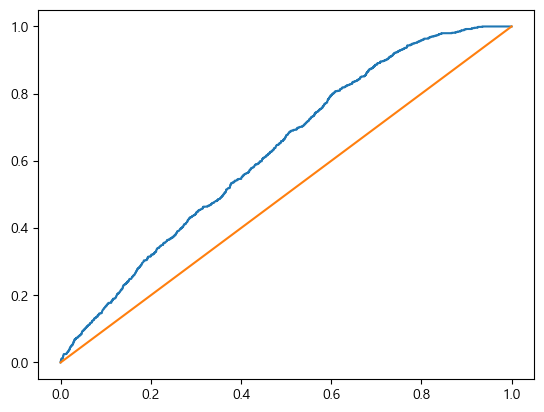

In [102]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

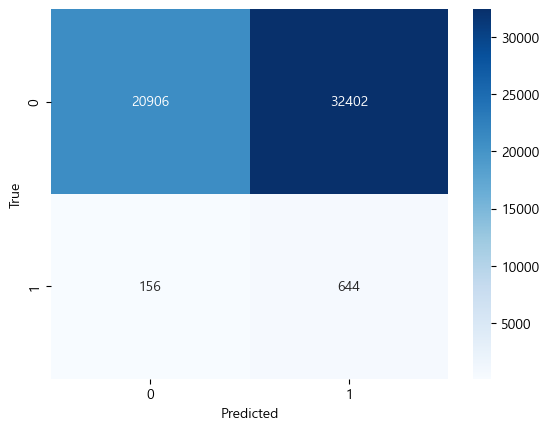

In [98]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap = 'Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [99]:
print("sensitivity :", cm[0,0]/(cm[0,0]+cm[0,1]))
print("specificity :", cm[1,1]/(cm[1,0]+cm[1,1]))

sensitivity : 0.3921737825467097
specificity : 0.805


In [ ]:
col_list = X.columns
smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
ros = RandomOverSampler()

In [ ]:
accuracy_lst, recall_lst, precision_lst, f1_lst, roc_lst = [], [], [], [], []

In [ ]:
# for train_index, test_index in kf.split(X_arr, y_arr):
#     X_train, X_test = X_arr[train_index], X_arr[test_index]
#     y_train, y_test = y_arr[train_index], y_arr[test_index]
#     X_test = pd.DataFrame(X_test, columns = col_list)
#     y_train2 = y_train.reshape(y_train.shape[0], 1)

#     # # Oversampling using SMOTETomek
#     start = time.time()
#     smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
#     X_smt, y_smt = smoteto.fit_resample(X_train, y_train2)
#     end = time.time()
#     print("Sampling Done :", end-start)

#     # Classification
#     start = time.time()
#     xgb_model.fit(X_smt, y_smt)
#     end = time.time()
#     print("Fitting Done :", end-start)

#     # Prediction
#     y_pred = xgb_model.predict(X_test)

#     # score
#     accuracy = accuracy_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
#     roc = roc_auc_score(y_test, y_pred)
#     print(accuracy, recall, precision, f1, roc)
    
#     # Confusion Matrix
#     cm = confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, cmap = 'Blues')
#     plt.show()

#     # as list
#     accuracy_lst.append(accuracy)
#     recall_lst.append(recall)
#     precision_lst.append(precision)
#     f1_lst.append(f1)
#     roc_lst.append(roc)

In [ ]:
print(np.mean(accuracy_lst))
print(np.mean(recall_lst))
print(np.mean(precision_lst))
print(np.mean(f1_lst))
print(np.mean(recall_lst))